In [11]:
import gymnasium as gym
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from minigrid.wrappers import ImgObsWrapper
from minigrid.core.world_object import Door # 引入 Door 类用于判断
from ablation_study import SimplePotentialShaping, HierarchicalPotentialShaping
from minigrid.core.world_object import Key, Door, Goal

In [12]:

def test_simple_shaping_correctness(total_steps=1000):
    """
    测试 SimplePotentialShaping 在 DoorKey 上的行为。
    预期：即使拿到钥匙，势能也只取决于 Agent 到 Goal 的距离。
    """
    ENV_ID = "MiniGrid-DoorKey-5x5-v0"
    
    env = gym.make(ENV_ID, render_mode="rgb_array")
    env = ImgObsWrapper(env)
    # 使用 Simple Shaping
    shaping_env = SimplePotentialShaping(env, shaping_weight=1.0) 
    
    test_log = {
        'Step': [],
        'Potential': [],
        'Has_Key': [],
        'Door_Open': [],
        'Agent_to_Goal_Dist': [], # 新增：记录实际距离
    }

    obs, info = shaping_env.reset(seed=42)
    
    print(f"--- 验证开始：SimplePotentialShaping (只看 Goal) ---")
    
    for t in range(total_steps):
        # A. 记录 step 之前的势能 Phi(s)
        phi_s = shaping_env.last_potential
        
        # B. 采取行动
        action = shaping_env.action_space.sample() # 随机探索
        obs, total_reward, terminated, truncated, info = shaping_env.step(action)
        
        # C. 获取 step 之后的势能 Phi(s')
        phi_s_prime = shaping_env.last_potential
        
        # D. 获取状态用于绘图
        unwrapped = shaping_env.unwrapped
        agent_pos = np.array(unwrapped.agent_pos)
        
        has_key = unwrapped.carrying is not None
        door_open = False
        goal_pos = None

        for i in range(unwrapped.grid.width):
             for j in range(unwrapped.grid.height):
                 obj = unwrapped.grid.get(i, j)
                 if isinstance(obj, Goal):
                     goal_pos = np.array((i, j))
                 if isinstance(obj, Door) and obj.is_open:
                     door_open = True

        # 计算 Agent 到 Goal 的实际距离
        dist_to_goal = np.abs(agent_pos - goal_pos).sum() if goal_pos is not None else -1
        
        # 记录
        test_log['Step'].append(t)
        test_log['Potential'].append(phi_s_prime) 
        test_log['Has_Key'].append(has_key)
        test_log['Door_Open'].append(door_open)
        test_log['Agent_to_Goal_Dist'].append(dist_to_goal)

        if terminated or truncated:
            obs, info = shaping_env.reset()
            
    df = pd.DataFrame(test_log)
    return df

In [13]:
def plot_simple_shaping_verification(df_simple):
    """
    绘制验证图表，观察 Simple Shaping 的势能变化
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    
    # 1. 势能变化 vs 距离
    axes[0].plot(df_simple['Step'], df_simple['Potential'], label='Simple Potential $\Phi_S(s)$', color='#f1c40f', linewidth=2)
    axes[0].plot(df_simple['Step'], 1.0 - df_simple['Agent_to_Goal_Dist'] / 10.0, label='1 - Normalized Distance to Goal', color='#34495e', linestyle='--', alpha=0.7)
    axes[0].set_ylabel("Potential Value")
    axes[0].set_title("Simple Potential $\Phi_S(s)$ Verification (Should only track Goal Distance)")
    axes[0].legend(loc='upper right')
    
    # 2. 关键状态 (Key/Door)
    axes[1].plot(df_simple['Step'], df_simple['Has_Key'], label='Has Key (1=Yes, 0=No)', color='orange', alpha=0.7)
    axes[1].plot(df_simple['Step'], df_simple['Door_Open'], label='Door Open (1=Yes, 0=No)', color='green', alpha=0.7)
    axes[1].set_yticks([0, 1])
    axes[1].set_ylabel("Status Flag")
    axes[1].set_xlabel("Time Step")
    axes[1].legend(loc='upper right')
    
    plt.tight_layout()
    plt.savefig("verification_simple_shaping.png", dpi=300)
    print("✅ Simple Shaping 验证图表已保存为: verification_simple_shaping.png")

--- 验证开始：SimplePotentialShaping (只看 Goal) ---
✅ Simple Shaping 验证图表已保存为: verification_simple_shaping.png


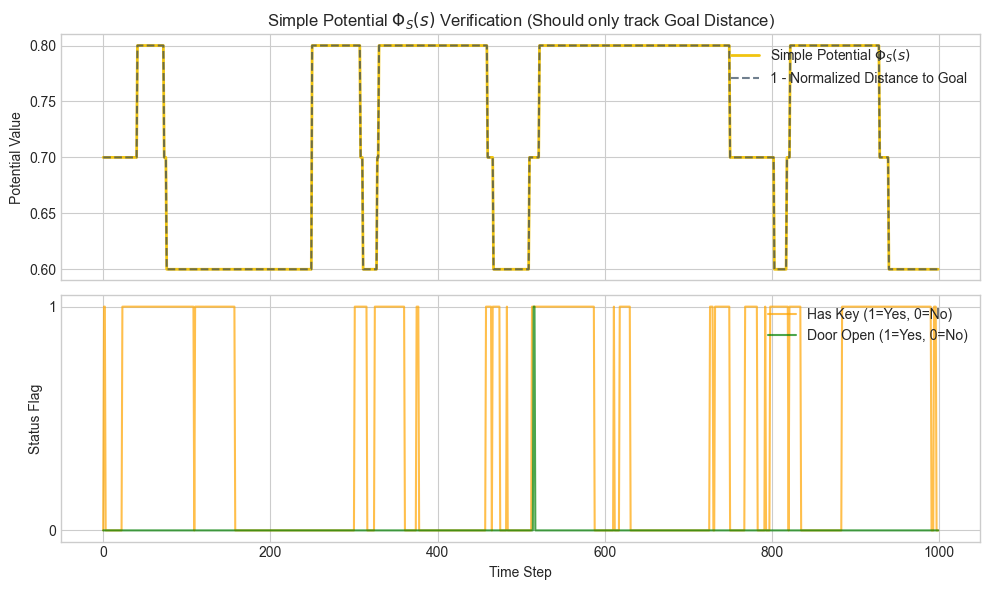

In [14]:
if __name__ == "__main__":
    df_simple = test_simple_shaping_correctness(total_steps=1000)
    plot_simple_shaping_verification(df_simple)